`# Treinamento de Rede Neural Recorrente para classificação`


## Setup

In [26]:
# Drive
from google.colab import drive

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()



```
# Import `matplotlib` and create a helper function to plot graphs:
```



In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

```
    # Setup input pipeline


# O dataset que vamos utilizar para treinamento e testes
# se chama RePro e está descrito no artigo https://aclanthology.org/2024.propor-1.44.pdf
```





In [28]:
# Conectando ao google drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 avaliacao_da_disciplina_2022_1.xlsx
 bitcoin_wallet_keywords.png
'Colab Notebooks'
 dataset_professora.csv
 dataset_professora.gsheet
 dataset_professora_predicoes.csv
 links_tcc
'Machine learning techniques for emotion detection and sentiment analysis  current state  challenges  and future directions.pdf'
 monero_wallet_keywords.png
 olist_customers_dataset.csv
 olist_preprocessado.csv
 PLN
 RePro.csv
 repro-main.zip
 ReProRnn.csv
 review_repro_preprocessado.csv
 reviews_ptbr.csv
 tcc_analise_sentimento1.xlsx
 tw_pt.csv


In [57]:
df = pd.read_csv("/content/drive/MyDrive/ReProRnn.csv")
df

,text,label
0,"ESSE PRODUTO PODE ATÉ SER BOM, PORÉM, A AMERIC...",3
1,"Aparelho muito bom, confiável e com valor aqui...",1
2,"As cores da impressão não são fiéis, O custo b...",0
3,"A história é muito boa, porém o autor ""enrolou...",3
4,"Entrega rápida, produto muito bom Amei. Pratic...",1
...,...,...
9998,amei o produto. chegou no prazo e em perfeito ...,1
9999,Ótima embalagem. Produto entregue no prazo. Re...,1
10000,"ótimo produto, super recomendo .,Entrega bem r...",1
10001,"Veio tudo certinho, dentro do prazo e o produt...",1


In [58]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=42)
type(train_dataset)

pandas.core.frame.DataFrame

In [59]:
def dataframe_to_dataset(df):
    # Separa colunas
    texts = df["text"].values
    labels = df["label"].values

    # Converte para tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    return ds

In [60]:
train_dataset = dataframe_to_dataset(train_dataset)
test_dataset = dataframe_to_dataset(test_dataset)

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [61]:
# Prepara os dados com shuffle e batching (mas sem aplicar o encoder aqui!)
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [62]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [63]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy())  # Removido o [:3]

texts:  [b'Produto de muito baixa qualidade e demorou muito mais que o previsto pra chegar! Agora \xc3\xa9 torcer pra ele nao quebrar na primeira utiliza\xc3\xa7\xc3\xa3o.'
 b'O produto \xc3\xa9 de baixa qualidade, nao oferece seguran\xc3\xa7a, nao \xc3\xa9 flexivel, regulavel e portanto, nao serviu as minhas necessidades.'
 b'Veio com Defeito e As Americanas n\xc3\xa3o me atenderam. Jogaram para uma Tal Fantasma chamada "OLIST". Irrespons\xc3\xa1veis. Perderam um Cliente!']

labels:  [0 0 0 2 3 1 1 0 1 3 0 2 0 1 0 3 0 3 1 1 3 1 0 0 1 2 0 3 0 0 1 0]


In [64]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    pad_to_max_tokens=True)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [65]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'o', 'e', 'a', 'de', 'não', 'que', 'produto', 'é',
       'muito', 'do', 'com', 'um', 'para', 'no', 'da', 'bom', 'mas', 'em'],
      dtype='<U14')

In [66]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8,   5,  10, 474,  30,   3, 321,  10,  23,   7,   2, 227,  43,
        231,  85,   9,   1,  43,  62,  61, 976,  20, 287, 844,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,   8,   9,   5, 474,  30,  61,   1, 754,  61,   9,   1,   1,
          3, 799,  61,   1,  28,  96, 266,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

In [67]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Produto de muito baixa qualidade e demorou muito mais que o previsto pra chegar! Agora \xc3\xa9 torcer pra ele nao quebrar na primeira utiliza\xc3\xa7\xc3\xa3o.'
Round-trip:  produto de muito baixa qualidade e demorou muito mais que o previsto pra chegar agora é [UNK] pra ele nao quebrar na primeira utilização                                                                                                    

Original:  b'O produto \xc3\xa9 de baixa qualidade, nao oferece seguran\xc3\xa7a, nao \xc3\xa9 flexivel, regulavel e portanto, nao serviu as minhas necessidades.'
Round-trip:  o produto é de baixa qualidade nao [UNK] segurança nao é [UNK] [UNK] e portanto nao [UNK] as minhas necessidades                                                                                                        

Original:  b'Veio com Defeito e As Americanas n\xc3\xa3o me atenderam. Jogaram para uma Tal Fantasma chamada "OLIST". Irrespons\xc3\xa1veis. Perderam um Cliente!'
Round-trip:  veio

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [68]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [69]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [70]:
# Compila o modelo
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [71]:
# Treina o modelo
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 155ms/step - accuracy: 0.4889 - loss: 1.3021 - val_accuracy: 0.5552 - val_loss: 1.0214
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.5933 - loss: 0.9334 - val_accuracy: 0.7198 - val_loss: 0.7321
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.7180 - loss: 0.7064 - val_accuracy: 0.7573 - val_loss: 0.6409
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.7606 - loss: 0.6176 - val_accuracy: 0.7698 - val_loss: 0.5962
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 149ms/step - accuracy: 0.7760 - loss: 0.5644 - val_accuracy: 0.7760 - val_loss: 0.5672
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.7895 - loss: 0.5156 - val_accuracy: 0.7833 - val_loss: 0.5543
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.8016 - loss: 0.4955 - val_accuracy: 0.7979 - val_loss: 0.5237
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.8278 - loss: 0

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [72]:
# Avalia o modelo
test_loss, test_acc = model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8132 - loss: 0.5149


With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [73]:
print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_acc)


Test Loss: 0.5099620819091797
Test Accuracy: 0.810094952583313


## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

Now, evaluate it again in a batch with a longer sentence. The result should be identical:

Compile the Keras model to configure the training process:

## Train the model

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [74]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # <- adaptado para 4 classes
])

In [75]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [76]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 274ms/step - accuracy: 0.4306 - loss: 1.3321 - val_accuracy: 0.6750 - val_loss: 0.8677
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - accuracy: 0.6667 - loss: 0.8814 - val_accuracy: 0.7458 - val_loss: 0.6720
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.7192 - loss: 0.7410 - val_accuracy: 0.7625 - val_loss: 0.6309
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 511ms/step - accuracy: 0.7619 - loss: 0.6522 - val_accuracy: 0.7708 - val_loss: 0.6174
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.7815 - loss: 0.6053 - val_accuracy: 0.7833 - val_loss: 0.5869
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 322ms/step - accuracy: 0.7978 - loss: 0.5684 - val_accuracy: 0.7865 - val_loss: 0.5627
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 327ms/step - accuracy: 0.8134 - loss: 0.5225 - val_accuracy: 0.7896 - val_loss: 0.5624
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 273ms/step - accuracy: 0.8268 - loss:

In [77]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.8189 - loss: 0.5376
Test Loss: 0.5324369072914124
Test Accuracy: 0.8080959320068359


In [78]:
sample_text = "I absolutely loved the movie! The plot was thrilling and the acting was superb."

# Garante que seja um tf.Tensor com dtype string
input_tensor = tf.constant([sample_text])

# Faz a previsão
prediction = model.predict(input_tensor)[0][0]

print("Logit:", prediction)
print("Sentimento:", "Positivo 😊" if prediction >= 0 else "Negativo 😠")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
Logit: 0.33468372
Sentimento: Positivo 😊


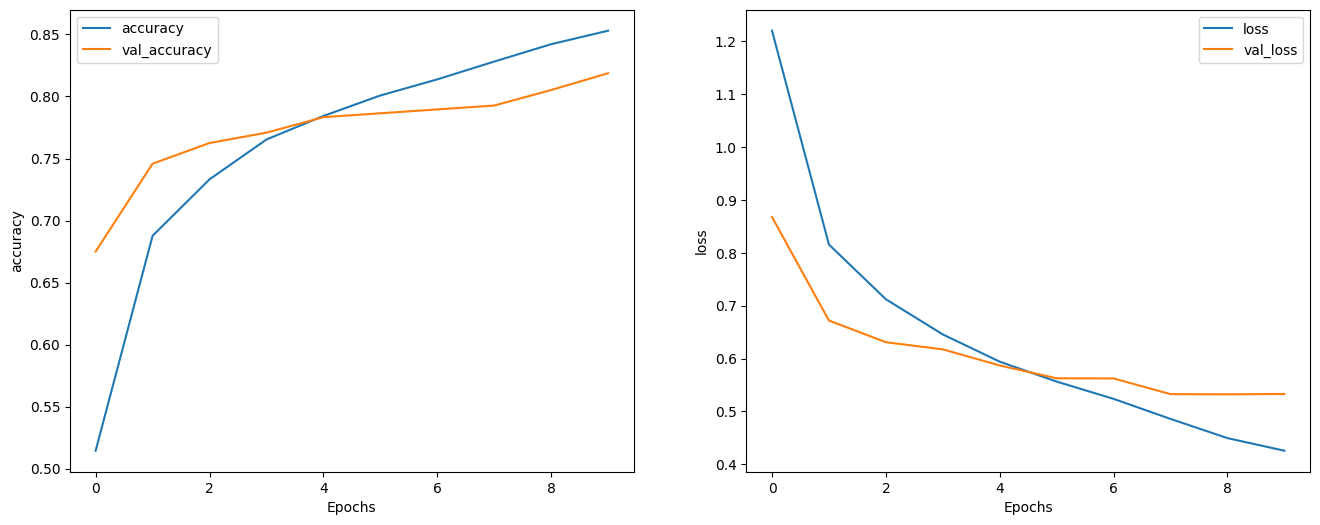

In [79]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
